# TogetherAI推出世界上LLM最快推理引擎，性能超过vLLM和TGI三倍

## TogetherAI推理引擎的方法结合了以下三个关键技术：
- FlashAttention-2：可以提高LLM的训练和微调速度4倍以上，并在NVIDIA A100s上实现了72%的模型FLOP利用率。这一点很重要，因为传统的注意力计算受内存带宽限制，通常会进行大量内存交换。Flash Attention重组矩阵运算以减少内存交换，使模型速度翻倍或更多；
- Flash-Decoding：加快推理过程中的注意力计算，对超长序列，生成速度可以提高8倍。对输入序列中的多个tokens通过重新组织句子计算可以批处理注意力计算。对短Prompt影响很小，但对于较长的序列（例如，10ktokens），性能可能会翻倍；
- Medusa：在LLM的最后隐藏状态之上添加多个头来预测下一个token，然后使用模型来验证这个预测的token，推理速度可以提高2倍。

## TogetherAI如何使用
https://www.together.ai/

设置虚拟环境
```
mkdir togetherai-serving && cd togetherai-serving
python3 -m venv togetherai-serving-env
source togetherai-serving-env/bin/activate

pip3 install ipykernel jupyter
pip3 install python-dotenv
pip3 install --upgrade together
pip3 install langchain huggingface_hub
# Optionally, fire up VSCode or your favorite IDE and let's get rolling!
code .
```
创建.env文件并添加TogetherAI API密钥
```
TOGETHER_API_KEY=<Your API Key>
```


In [ ]:
import os
import time
import json
import logging
from datetime import datetime
import together
from langchain.llms.base import LLM
from langchain import PromptTemplate,  LLMChain
from dotenv import load_dotenv # The dotenv library's load_dotenv function reads a .env file to load environment variables into the process environment. This is a common method to handle configuration settings securely.
# Load env variables
load_dotenv()
# Set up logging
logging.basicConfig(level=logging.INFO)

查看支持的模型

In [ ]:
model_list = together.Models.list()
print(f"There are {len(model_list)} models to choose from!")
[model['name'] for model in model_list][:20]

使用“togethercomputer/lama-2–7b chat”来生成一个回复

In [ ]:
prompt = "<human>: What do you think about Large Language Models?\n<bot>:"
model = "togethercomputer/llama-2-7b-chat"
output = together.Complete.create(
    prompt = prompt,  
    model = model,   
    max_tokens = 256,  
    temperature = 0.8,  
    top_k = 60,  
    top_p = 0.6,  
    repetition_penalty = 1.1,  
    stop = ['<human>', '\n\n']
    )
print(json.dumps(output, indent = 4))

In [ ]:
print(output['output']['choices'][0]['text'])

"""
Large language models, such as transformer-based models like BERT and 
RoBERTa, have been instrumental in achieving state-of-the-art results 
in a wide range of natural language processing (NLP) tasks. These models 
are trained on large amounts of text data and have the ability to learn 
complex patterns and relationships in language.
"""

流式输出

In [ ]:
for token in together.Complete.create_streaming(prompt=prompt):
    print(token, end="", flush=True)

## ToggetherAI与Langchain的集成
有一个创建自定义LLM包装器的示例代码（https://python.langchain.com/docs/modules/model_io/llms/custom_llm），将通过类型验证、异常处理和日志记录使其变得更好

In [ ]:
class TogetherLLM(LLM):    
    """    
    Together LLM integration.

    Attributes:        
        model (str): Model endpoint to use.        
        together_api_key (str): Together API key.        
        temperature (float): Sampling temperature to use.        
        max_tokens (int): Maximum number of tokens to generate.    
    """        
    
    model: str = "togethercomputer/llama-2-7b-chat"    
    together_api_key: str = os.environ["TOGETHER_API_KEY"]    
    temperature: float = 0.7    
    max_tokens: int = 512

    @property    
    def _llm_type(self) -> str:       
        """Return type of LLM."""        
        return "together"
    
    def _call(self, prompt: str, **kwargs: Any) -> str:            
        """Call to Together endpoint."""            
        try:                
            logging.info("Making API call to Together endpoint.")                
            return self._make_api_call(prompt)            
        except Exception as e:                
            logging.error(f"Error in TogetherLLM _call: {e}", exc_info=True)   
            raise

    def _make_api_call(self, prompt: str) -> str:        
        """Make the API call to the Together endpoint."""        
        together.api_key = self.together_api_key        
        output = together.Complete.create(            
            prompt,            
            model=self.model,            
            max_tokens=self.max_tokens,            
            temperature=self.temperature,        
            )        
        logging.info("API call successful.")        
        return output['output']['choices'][0]['text']

- langchain.lms.base模块通过提供比直接实现_generate方法用户更友好的界面来简化与LLM的交互。       
- 类langchain.lms.base.LLM是LLM的一个抽象基类，这意味着它为其他类提供了一个模板，但并不意味着它自己被实例化。它旨在通过在内部处理LLM的复杂性，为LLM的工作提供一个更简单的界面，允许用户更容易地与这些模型交互。
- __call__方法允许像函数一样调用类，它检查缓存并在给定提示下运行LLM。

In [ ]:
llm = TogetherLLM(
    model = model,    
    max_tokens = 256,    
    temperature = 0.8
    )

In [ ]:
prompt_template = "You are a friendly bot, answer the following question: {question}"
prompt = PromptTemplate(    
    input_variables=["question"], 
    template=prompt_template
    )

chat = LLMChain(llm=llm, prompt=prompt)

In [ ]:
chat("Can AI take over developer jobs?")

## 管理聊天历史记录
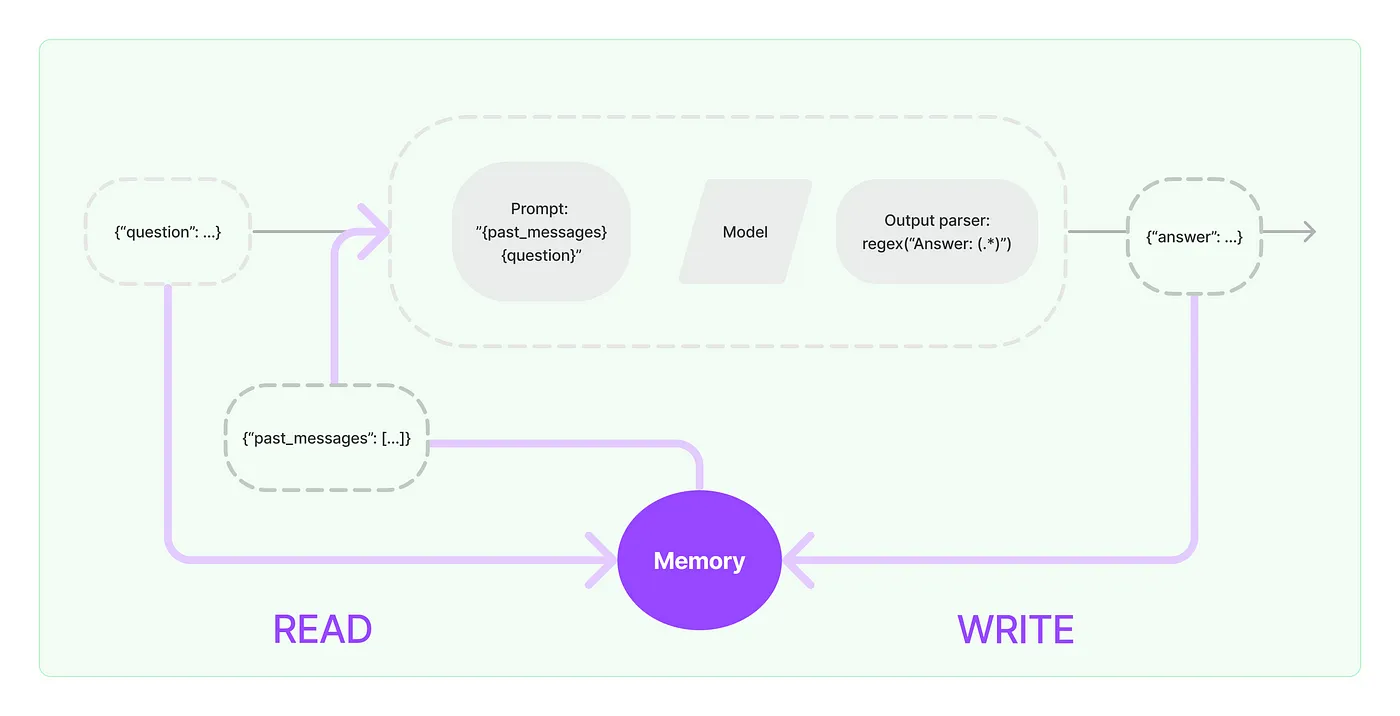

In [ ]:
from typing import List
class LLMChain:    
    def __init__(self, llm, prompt):        
        self.llm = llm        
        self.prompt = prompt        
        self.history: List[str] = []  # Initialize an empty list to keep track of the conversation history
    
    def add_to_history(self, user_input: str, bot_response: str):        
        self.history.append(f"<human>: {user_input}")        
        self.history.append(f"<bot>: {bot_response}")
    
    def generate_prompt(self, question: str) -> str:        
        history_str = "\n".join(self.history)  # Convert the history list into a single string        
        return f"{history_str}\n<human>: {question}\n<bot>:"
    
    def ask(self, question: str) -> str:        
        full_prompt = self.generate_prompt(question)        
        response = self.llm._call(full_prompt)  # Assuming _call method handles the actual API call        
        self.add_to_history(question, response)        
        return response

每次调用ask方法时，会话历史都会更新为最新的交换。generate_prompt方法构造一个包含此历史记录的新Prompt来维护会话的上下文

In [ ]:
# Usage
llm = TogetherLLM(    
    model = model,    
    max_tokens = 256,    
    temperature = 0.8
    )

prompt_template = "You are a friendly bot, answer the following question: {question}"
prompt = PromptTemplate(    
    input_variables=["question"], 
    template=prompt_template
    )

chat = LLMChain(llm=llm, prompt=prompt)

# Example interaction
response = chat.ask("What is the weather like today?")
print(response)  # Bot's response

# The next call to chat.ask will include the previous interaction in the prompt
response = chat.ask("How can I enjoy such a weather?")
print(response)